In [1]:
%matplotlib inline

import numpy as np
import scipy
import math
import json
import pprint
import time
import copy
from matplotlib import pyplot as plt
import itertools
import pandas as pd
import cProfile
import csv
import inspect

import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../')

from mx_sys.power_calcs import power_calcs as makani_FBL
from mx_sys.power_calcs import kite_pose
from mx_sys.power_calcs import kite_loop
from mx_sys.power_calcs import kite_path

import m600_fbl_config_manager as cm
import resource_fbl_manager as rm

reload(makani_FBL)
reload(cm)
reload(rm)

<module 'resource_fbl_manager' from '../resource_fbl_manager.pyc'>

# Setup Kite and Environment

The easiest way to create a kite and resource is to use the managers.

However, they are both just dictionaries. Required and optional elements of the dictionary are specified in the docstrings for the various objects that use them. You can always create, edit, and overwrite the various parts of the configs and resource however you'd like manually.

There are a several options for aero models. There are 2 types:
1. Body coefficient models
    - Provide cx, cy, cz as a function of alpha and (optional) beta
2. Aero coefficient models
    - Provide cL, cY, cD as a function of alpha and (optional) beta
    
Either type must also return moment coefficients cl, cm, and cn.
    
See docstrings for details on how to name things, and error messages will point out missing functions.

In [2]:
# using the resource and config managers
resource = rm.GetResourceByName()
other_resource = rm.MakeResourceByShearAndHref(0.2, 80., 1.075, 8.)

base_kite = cm.GetConfigByName()
#M600 does NOT SOLVE high winds with roll limits in place
#removing those limits for a clean example
base_kite.pop('roll_min')
base_kite.pop('roll_max')

print 'Resource:'
pprint.pprint(resource)
print
print 'Other Resource:'
pprint.pprint(resource)
print
print 'Base Kite:'
pprint.pprint(base_kite.keys())
print

# example of resource functions
print inspect.getsource(resource['v_w_at_height'])
print inspect.getsource(other_resource['v_w_at_height'])

# defining a config manually
def rotors_simple(rho, v_a, force):
    power_shaft = v_a * -force
    out = {'power_shaft': power_shaft}
    return out

other_kite = {
    'alpha_min': 0.,
    'alpha_max': 7.,
    'cD_eff_tether': 0.06,
    'gs_position': (0.,0.,0.),
    'eta_shaft_to_pad': lambda p: 0.82,
    'bridle_moment_from_tether_pitch_roll': (
        lambda p, r: np.array([0., 0., 0.])),
    'l_tether': 430.,
    'v_a_min': 30.,
    'v_a_max': 70.,
    'shaft_power_from_drag_power': rotors_simple,
    'rotor_thrust_center': np.array([0., 0., 0.]),
    'm_kite': 1200.,
    'h_min': 80.,
    'm_tether': 300.,
    'aero_coeff_from_alpha_beta': lambda a, b, o: {
        'cL': 0.11 * a, 'cY': 0.01 * b, 'cD': 0.05 + (0.04 * a)**2,
        'cl': 0.1, 'cm': 0.2, 'cn': 0.},
    'CG': np.array([0., 0., 0.]),
    'tension_max': 250000.,
    'beta_min': -5.,
    'beta_max': 5.,
    'c': 1.28,
    'b': 25.66,
    's': 32.9,
    'inertia': np.array([[3000., 0., 0.],
                         [0., 3000., 0.],
                         [0., 0., 3000.]]),
    'power_shaft_max': 900000.}

Resource:
{'rho': 1.075,
 'v_w_at_height': <function <lambda> at 0x115bcfaa0>,
 'v_w_avg_h_ref': 8.0}

Other Resource:
{'rho': 1.075,
 'v_w_at_height': <function <lambda> at 0x115bcfaa0>,
 'v_w_avg_h_ref': 8.0}

Base Kite:
['alpha_min',
 'cD_eff_tether',
 'gs_position',
 'eta_shaft_to_pad',
 'bridle_moment_from_tether_pitch_roll',
 'l_tether',
 'v_a_max',
 'incl_max',
 'shaft_power_from_drag_power',
 'rotor_thrust_center',
 'cL_offset',
 'v_a_min',
 'alpha_max',
 'm_kite',
 'description',
 'h_min',
 'm_tether',
 'body_coeff_from_alpha_beta',
 'CG',
 'tension_max',
 'beta_max',
 'c',
 'b',
 'cD_offset',
 's',
 'beta_min',
 'inertia',
 'power_shaft_max']

                       'v_w_at_height': lambda h, v_w: v_w,

  def v_w_at_height(height, v_w_at_ref):
    v_w = v_w_at_ref * (height / h_ref)**shear
    return v_w



There are several helper functions to plot things scattered about. As an example, we can inspect the aero database to find where the Loyd limit is.

The Loyd limit is defined as:
$\zeta_{max} = \frac{4}{27}\frac{C_L^3}{C_D^2}$ 

$v_{a\_best\_power} \approx v_{k\_best\_power} \approx \frac{2}{3}\frac{L}{D} v_w$ 

Derivations won't be shown here, but results are below:

Max zeta 32.34 for cL of 3.10, cL/cD is 10.28 at alpha 9.33 and beta -2.61.


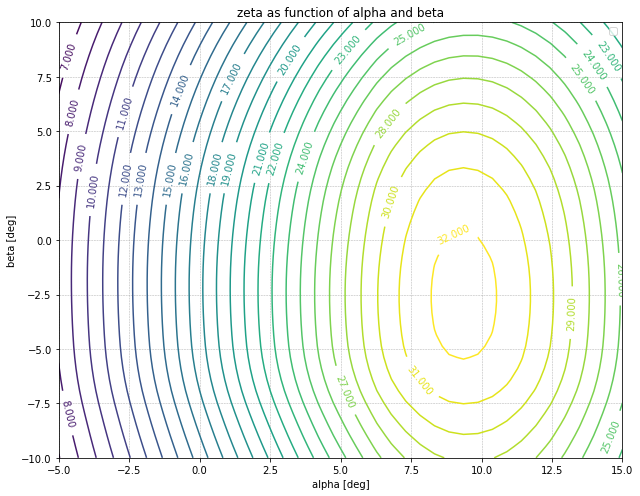

In [3]:
zeta, cL, L_over_D, alpha, beta = makani_FBL.calc_loyd_optimums(base_kite)

plots = cm.PlotKiteAero(base_kite, keys=['zeta'])

# Create Path Object (optional)

Section is optional as you don't need to know how to create a path object as they are usually created and managed by the higher level object, KiteLoop.  
KitePath creates and holds all the path definition needed for the FBL model.

You can create it by manually making the params, or by using the config manager helper function to make an entire set of args for the M600 by specifying a min height and a loop radius.

A path mostly just contains the positions, but also has a few summary values.

In [4]:
# using config helper function to get args and splatting it into KitePath
path_args = cm.GetPathArgsByR_LoopAndMinHeight(base_kite, 100., 130.)
print 'Path_Args:'
pprint.pprint(path_args)
print

path = kite_path.KitePath(config=base_kite, **path_args)

# pull off one position to use later
position = path.positions[0]

# print some stuff from the path
print 'Example Position:'
pprint.pprint(position)
print
print 'Example path summary data:'
print 'Half cone angle: %0.2f deg' % math.degrees(path.half_cone_angle)
print('Min height in loop: %0.1f m' % path.h_min)
print 'Virtual Hub Height: %0.2f m' % path.h_hub

# make a path manually
shape_params = {'type': 'circle',
                'r_loop': 140.}
location_params = {'azim': 0.,
                   'incl': 0.}

other_path = kite_path.KitePath(shape_params, location_params, base_kite)

Path_Args:
{'location_params': {'azim': 0.0, 'incl': 0.4928164685071619},
 'shape_params': {'r_loop': 130.0, 'type': 'circle'}}

Example Position:
{'azim': 0.0,
 'crosswind_xy': array([-3.10862447e-15,  1.24174726e+02]),
 'e_path_tangent': array([ 0., -1.,  0.]),
 'e_tether_incl': array([ 0.71267988,  0.        , -0.70148941]),
 'e_tether_rad': array([-0.70148941,  0.        , -0.71267988]),
 'incl': 0.7933111042093014,
 'loop_angle': -0.0,
 'loop_angle_csim': 4.71238898038469,
 'r_curv': 130.0,
 'r_curv_hat': array([ 0.47310908,  0.        , -0.88100386]),
 'segment_length': 45.378560551852566,
 'xyz': array([308.09414798,   0.        , 329.06100303])}

Example path summary data:
Half cone angle: 17.22 deg
Min height in loop: 100.0 m
Virtual Hub Height: 214.53 m


# Creating a KitePose object (optional)
A KitePose is the base level object to complete a force balance. It is a single point model of a kite. There are many options here, but this section is optional as typical use only uses the higher level objects, which will manage KitePoses automatically.

There are 2 solve options:
1. Lift roll angle is not provided
  - It is solved for to make the residual zero, if possible
2. Lift roll angle is provided
  - Orientation is fully specified, but the force balance is not likely
  
For either solution, you must specify a kite speed, either airspeed (v_a) or inertial speed (v_k), and optionally an acceleration along the flight path, body rates, and body accelerations. Gravity and curvature accelerations are applied as a result from the speed and path definition.

Poses can always be solved, but user beware. Just because it solves doesn't mean all the constraints are valid or that the forces were able to be balanced. You need to check it yourself.

Below shows running for a specified lift_roll_angle and without. As a solution fills the pose state, a new pose is needed each time - there is no way to reset a pose.

pose.state is the holder for all the info about the pose. When in doubt about what pose info is available and what keys to use when accessing data from higher level objects, inspect this dictionary.

## Important Note:
**FBL will return solutions that aren't valid - ie: either some constraint is violated or the force balance wasn't possible with the parameters given.**  

The results are just a function of the state provided. If no lift roll angle is provided, we can solve for the lift roll angle to meet the force balance, which usually works unless you lack enough lift.

The user has information to determine the validity of the solve. Every object has a "valid" attribute that keeps track of this. Violated constraints will show up in KitePose.constraints_violated (also stored in state).

In [5]:
# standard solver

# solving with a known aero state
# using kite with body coefficient aero model and v_a
pose = kite_pose.KitePose(position, resource, base_kite,
                            v_a=50., alpha=5., beta=0.,
                            v_w_at_h_ref=7.5, verbose=True)
pose.solve(solve_type='unknown_roll')
print 'Known aero state solution power:', pose.state['power']
print 'Pose is valid: ', pose.valid
print

# solving with a known lift_roll_angle
# using kite with aero coefficient aero model and v_k, with accel
pose = kite_pose.KitePose(position, resource, base_kite,
                            v_a=50., alpha=5., beta=0., lift_roll_angle=-0.1,
                            v_w_at_h_ref=7.5, verbose=True)
pose.solve(solve_type='full')
print 'Known aero state solution power:', pose.state['power']
print 'Pose is valid: ', pose.valid
print


print 'Example of data stored in pose.state using solution from known tension solution.'
pprint.pprint(pose.state)

Known aero state solution power: -92736.7181336149
Pose is valid:  True

Pose is not valid. Constraints violated are: 
[{'lim_type': 'zero', 'name': 'net_margin', 'margin_norm': -3.6592680409253364, 'value': 6340.190233737926, 'limit': 0.0, 'margin': -6340.190233737926}]
Known aero state solution power: -87027.16274045788
Pose is valid:  False

Example of data stored in pose.state using solution from known tension solution.
{'DCMf2b': array([[-0.9961947 , -0.00870106,  0.08672033],
       [ 0.        ,  0.99500417,  0.09983342],
       [-0.08715574,  0.09945352, -0.99121787]]),
 'DCMg2a': array([[ 0.15      ,  0.988686  ,  0.        ],
       [-0.63617175,  0.09651776,  0.76548666],
       [ 0.75682594, -0.114823  ,  0.64345176]]),
 'DCMg2b': array([[-0.08346748, -0.99493123,  0.05608052],
       [-0.63617175,  0.09651776,  0.76548666],
       [-0.76701936,  0.0282164 , -0.64100323]]),
 'DCMg2f': array([[ 0.15      ,  0.988686  ,  0.        ],
       [-0.70855006,  0.10749875,  0.69742

# Creating KiteLoop objects

KiteLoop objects are a container for a "set" of poses that define an entire loop. The KiteLoop applies accelerations to each pose to make them consistent with the speed strategy applied.

Any necessary variable that isn't specified is determined by an optimizer, with a default seed. Alternatively, you can explictly define a variable to optimize over and set your own seed value and parameterization type. See docstring for parameterization types and usage.

There are also optimization options, under the keyword arg 'opt_params'. Selection of optimization options is the single most finicky part of the process, and the most likely to cause errors or non-optimal results. There are a lot of options for the optimizer. See docstring for options, but defaults should be pretty good.

Two frequently used ones are 'tol' and 'constraint_stiffness'.  
'tol' is the convergence tolerance. Higher values will take longer to finish, but results will be smoother and make more power. Typical values are ~0.01 - 0.001.
'constraint_stiffness' is a weighting factor for constraints. Higher values will make the model more quickly shy away from constraints violations, while lower ones will let the model optimize power first, then try and meet constraints, but can be harder to converge. Typical values are ~1. to 0.01.

Note that at high wind speeds, you many need to provide a better seed, as this space is highly constrained. The KitePowerCurve handles this automatically by seeding loops with the previous loops best v_k strategy, which usually works well for finding a solution.

Optimizing loop...
Variables being optimized:  ['r_loop', 'azim', 'beta', 'v_a', 'alpha', 'incl']
Initial seed is: 
{'alpha': array([3., 3., 3., 3., 3., 3.]),
 'azim': array([0.]),
 'beta': array([3., 3., 3., 3., 3., 3.]),
 'incl': array([0.4]),
 'r_loop': array([120]),
 'v_a': array([40., 40., 40., 40., 40., 40.])}
Parameterization types are: 
r_loop: value
azim: value
beta: spline
v_a: spline
alpha: spline
incl: value
Max iter: 700, calculating iter 0..100..
Optimization complete in 151 iterations and 3.54s.
Converged to solution.
Results for optimization in normalized domain: 
[0.947, 0.628, 0.706, 0.855, 0.993, 0.993, 1.62, -0.023, 0.69, 0.767, -0.146, -0.159, 0.151, 0.613, -0.323, -0.337, 2.713, 3.997, 1.777, 0.272, -0.915]
Results for optimization in parameter domain: 
{'alpha': array([4.89325448, 4.25567316, 4.4118248 , 4.70916857, 4.98599591,
       4.98538519]),
 'azim': array([-0.08100879]),
 'beta': array([2.95434372, 4.37901376, 4.53301595, 2.70793468, 2.68105789,
       3.

,DCMf2b,DCMg2a,DCMg2b,DCMg2f,accel_along_path,accel_power,aero_power,alpha,azim,beta,...,v_a_vec,v_k,v_k_hat,v_k_vec,v_w,v_w_hat,v_w_vec,valid,xyz,zeta_padmount
0,"[[-0.9947811186040963, -0.054404162039894684, ...","[[0.3329618736345494, 0.9429402901063091, 0.0]...","[[-0.23604304011125754, -0.9716286336719836, 0...","[[0.3329618736345494, 0.9429402901063091, 0.0]...",1.841302,-46138.083362,-196759.904287,5.000000,-0.081009,3.052650,...,"[11.687069659390794, 33.097509738349515, 0.0]",33.206407,"[-0.08092021593319032, -0.9967205820355701, 0.0]","[-2.687069659390793, -33.097509738349515, 0.0]",9.0,"[1.0, 0.0, 0.0]","[9.0, 0.0, 0.0]",True,"[337.02740639357023, -27.362062138892924, 296....",1.539402
1,"[[-0.9949691459140109, -0.05702754253457586, 0...","[[0.1793973520740274, 0.9348375874320658, 0.30...","[[-0.080471345480213, -0.9503615496675074, -0....","[[0.1793973520740274, 0.9348375874320658, 0.30...",3.707762,-156524.998650,-225596.312089,4.954736,-0.194397,2.920658,...,"[6.597164777483622, 34.37775158425802, 11.2684...",36.257148,"[0.06627204127146362, -0.9481647973455833, -0....","[2.4028352225163783, -34.37775158425802, -11.2...",9.0,"[1.0, 0.0, 0.0]","[9.0, 0.0, 0.0]",True,"[336.7341587235859, -66.29750078983427, 290.11...",9.034706
2,"[[-0.995049917857215, -0.06717852735486136, 0....","[[0.013095278737786337, 0.8022974540751523, 0....","[[0.08601555328895787, -0.7945971318542476, -0...","[[0.013095278737786337, 0.8022974540751523, 0....",5.883635,-321100.051390,-296202.283145,4.799388,-0.287019,3.084691,...,"[0.5284429944586577, 32.37567352076842, 24.082...",41.229958,"[0.20547091222761749, -0.785246344673652, -0.5...","[8.471557005541342, -32.37567352076842, -24.08...",9.0,"[1.0, 0.0, 0.0]","[9.0, 0.0, 0.0]",True,"[342.1742896469598, -100.9993520621305, 272.20...",14.049380
3,"[[-0.9949201716946232, -0.08071495174709728, 0...","[[-0.136481692860543, 0.5516653404679124, 0.82...","[[0.22902191644636472, -0.5120358454404291, -0...","[[-0.136481692860543, 0.5516653404679124, 0.82...",7.552263,-507792.827100,-419800.637633,4.557084,-0.346341,3.555294,...,"[-6.204141440069046, 25.077427808167627, 37.40...",47.529732,"[0.3198869587414187, -0.5276155938322943, -0.7...","[15.204141440069046, -25.077427808167627, -37....",9.0,"[1.0, 0.0, 0.0]","[9.0, 0.0, 0.0]",True,"[352.6916390865513, -127.28206054756276, 244.7...",16.925409
4,"[[-0.9945624399287444, -0.09285359200136822, 0...","[[-0.24162131920410393, 0.21803022879020112, 0...","[[0.31963400974796385, -0.1495372591075837, -0...","[[-0.24162131920410393, 0.21803022879020112, 0...",7.766862,-628685.427080,-588500.686104,4.330229,-0.369107,4.124906,...,"[-12.320300661569124, 11.117388071773915, 48.2...",53.877249,"[0.3957199170022975, -0.20634661559791168, -0....","[21.320300661569124, -11.117388071773915, -48....",9.0,"[1.0, 0.0, 0.0]","[9.0, 0.0, 0.0]",True,"[367.01765948039935, -141.97554371132233, 211....",19.707279
5,"[[-0.9941028726560526, -0.10154489008498696, 0...","[[-0.2870486303824679, -0.14786393863111164, 0...","[[0.3466401517067876, 0.23066616071806514, -0....","[[-0.2870486303824679, -0.14786393863111164, 0...",6.122931,-593927.366016,-771729.472686,4.221088,-0.357680,4.580040,...,"[-16.02759287052329, -8.256102826388002, 52.84...",59.051963,"[0.4238232130687236, 0.1398108098292863, -0.89...","[25.02759287052329, 8.256102826388002, -52.844...",9.0,"[1.0, 0.0, 0.0]","[9.0, 0.0, 0.0]",True,"[383.42442133946275, -143.3075506311438, 175.2...",25.350444
6,"[[-0.9937693268171849, -0.10607670458633377, 0...","[[-0.26917782805653445, -0.4931336807903707, 0...","[[0.31159870669258394, 0.5710356623879012, -0....","[[-0.26917782805653445, -0.4931336807903707, 0...",2.842305,-368835.197385,-920722.715071,4.249480,-0.316806,4.789023,...,"[-15.9214370847235, -29.168066811999868, 48.93...",62.178121,"[0.40080717467460913, 0.4691049882032759, -0.7...","[24.9214370847235, 29.168066811999868, -48.931...",9.0,"[1.0, 0.0, 0.0]","[9.0, 0.0, 0.0]",True,"[399.9330270455217, -131.11742161

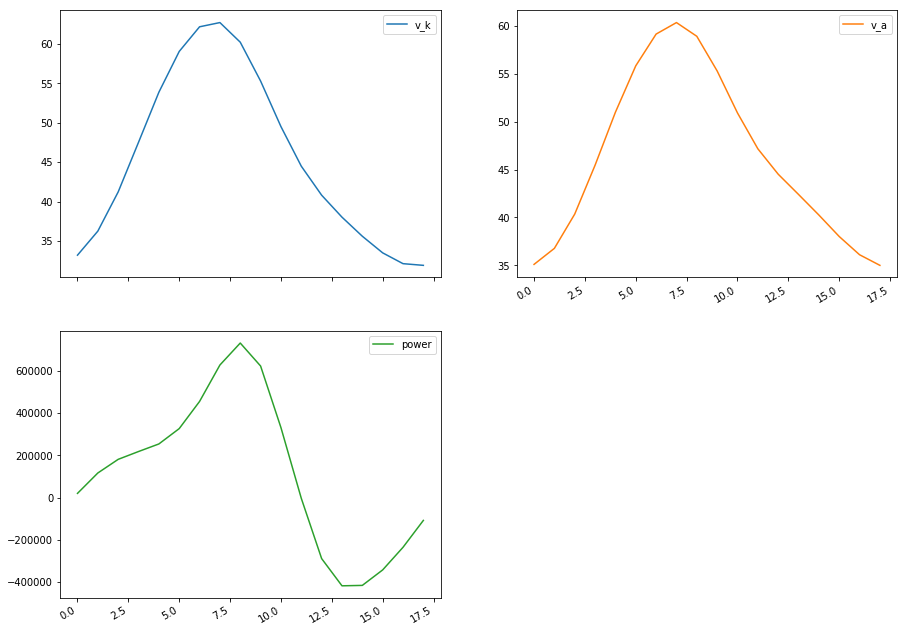

In [6]:
# make a loop with some options and solve it
loop = kite_loop.KiteLoop(
    resource, base_kite, v_w_at_h_ref=9.,
    verbose=True,
    opt_params={'tol':0.01,
                'constraint_stiffness': 0.01,
                'maxiter':700},
    vars_to_opt={'v_a': {'param_type': 'spline',
                         'values': [40.]*6,
                         'max_step': 5.}})
loop.solve()

# look at some summary data about loop
print
print 'Loop mean power: %0.2f W' % loop.power
print 'Loop average v_a: %0.2f m/s' % loop.data_loop['v_a_avg_time']
print 'Loop valid: ', loop.valid
print

# use Dataframe plotting library
loop.data_poses.plot(y=['v_k', 'v_a', 'power'],
                     subplots=True, figsize=(15, 12), layout=(2,2))

# use Dataframe feature in jupyter to make table of data
loop.data_poses

## KiteLoop - Using specific values instead of the optimizer

There are several ways to specify values to hold fixed. If all values are specified, the optimizer isn't used at all, and the solution time is very quick (thousandths of a sec).  

See the example below for formats to specify a particular solution, or the docstring. Any single variable can be dropped out and the optimizer will take over only that variable, using defaults optimizer options and seed unless something is specified in the "vars_to_opt" dictionary, as shown in the example above.

This methodology is useful when you just want to locally perturb something to see sensitivities, holding everything else constant. In this example, we sweep out varius azimuths, showing the power variation as the loop is slewed to the right.

Solving poses in loop...solved. Time is 0.0143s
Loop solved, now calculating loop data.
Loop Valid: True 
Loop Mean Power is: -278445.6 W
Extracting pose data into DataFrame.

Solving poses in loop...solved. Time is 0.0142s
Loop solved, now calculating loop data.
Loop Valid: True 
Loop Mean Power is: -248282.3 W
Extracting pose data into DataFrame.

Solving poses in loop...solved. Time is 0.0138s
Loop solved, now calculating loop data.
Loop Valid: True 
Loop Mean Power is: -224804.2 W
Extracting pose data into DataFrame.

Solving poses in loop...solved. Time is 0.0113s
Loop solved, now calculating loop data.
Loop Valid: True 
Loop Mean Power is: -208176.7 W
Extracting pose data into DataFrame.

Solving poses in loop...solved. Time is 0.0126s
Loop solved, now calculating loop data.
Loop Valid: True 
Loop Mean Power is: -198514.0 W
Extracting pose data into DataFrame.

Solving poses in loop...solved. Time is 0.0154s
Loop solved, now calculating loop data.
Loop Valid: True 
Loop Mean Powe

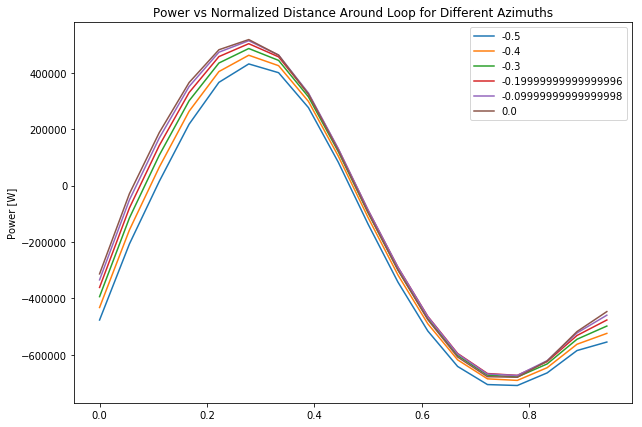

In [7]:
loops = []
azims = np.linspace(-0.5, 0, 6)

for azim in azims:
    temp_loop = kite_loop.KiteLoop(
        resource, base_kite, v_w_at_h_ref=7.5, verbose=True,
        path_location_params={'azim': azim,
                              'incl': 0.577},
        pose_states_param={'alpha': {'param_type': 'linear_interp', 'values': [4., 3., 3.5, 4.]}},
        pose_states={'beta': np.array([-3.]*18),
                     'v_k': np.array([ 42.18902103,  44.9445889 ,  47.92323029,  50.84411908,
                                       53.44207691,  55.55595166,  57.06702792,  57.85671546,
                                       57.80642404,  56.79756345,  54.72297007,  51.73829244,
                                       48.26199128,  44.72395391,  41.55406766,  39.18221986,
                                       38.03770241,  38.34796218])},
         path_shape_params={'type': 'circle',
                            'r_loop': 160.,
                            'num_pos': 18})
    temp_loop.solve()
    print
    loops.append(temp_loop)

plt.figure(figsize=(10,7))
plt.title('Power vs Normalized Distance Around Loop for Different Azimuths')
plt.ylabel('Power [W]')
for azim, loop in zip(azims, loops):
    plt.plot(loop.data_poses['dist_norm'],
             loop.data_poses.power_shaft,
             label=azim)
plt.legend()

# Using the Plotly Plotting Library

The KiteLoop contains a few tools that output the 3D force solution, as well as variables colored by value around the loop.

The plotting tool can be found at:
mx_modeling/visualizations/power_calcs_plotting_tool/plotter.html

Open it directly with your browser, and point it to the files generated by the KiteLoop.

In [8]:
# make files for plotly plotter
loop.gen_loop_vec_plot_file('test_forces.json')
loop.gen_loop_positions_plot_file('test_colors_roll_angle.json',
                                  var_to_color='tether_roll_angle')

File saved to test_forces.json.
File saved to test_colors_roll_angle.json.


# Creating a KitePowerCurve object

A KitePowerCurve object creates KiteLoop objects for each wind speed in the range.

All the same optimization parameters, options, etc that were available at the loop level are available here as well (opt_params, vars_to_opt, loop_params, path_shape_params, path_location_params), with the same effect.

Here is an example of not specifying anything and letting the defaults do the job.

Solutions for previous loops are used to seed the solutions for future loops, usually enabling the KitePower curve to more quickly and easily find solutions.

There are three key outputs that trim the data to make a power curve. 
1. KitePowerCurve.powers is average power for each loop
2. KitePowerCurve.powers_valid has invalid loop powers set to None
3. KitePowerCurve.powers_final has negative powers, invalid powers, and powers at virtual hub speeds outside of cut in and cut out (if provided in the kite config) set to zero

In [9]:
pc = makani_FBL.KitePowerCurve(resource, base_kite,
                                v_w_at_h_ref_range=(2., 10.), v_w_step=2.)
pc.solve()
print 'Validity of each loop: ', pc.valids

Now solving for v_w at h_ref: 2.0, 4.0, 6.0, 8.0, 
Time to solve power curve is 44.13s
Validity of each loop:  [True, True, True, True]


## Multiple Ways to Get Data

There's a ton of data in the KitePowerCurve object, and lot of ways to get it.
Summary level data is an attribute of the object, and the loop summaries are aggregated into a Dataframe object called:  
self.data_loops

The loops themselves are available in a list at self.loops. You can then pull out a loop and access all the pose data, or use the loop plotting tools.

Below are examples of different ways to get data out.
1. Directly access the data and do whatever with it: math, plot it, whatever 

    Most key data is available as an attribute as well, but the full set is in the data_loops or data_poses Dataframes.
    
2. Use the pandas Dataframe to do whatever, including its own plotting library 
3. Use the plotting helper functions included with some of the objects to plot things . These built in plotting tools do a lot more formatting for you, as shown in the example below.

**Note: The surface plots are way nicer and actually functional if you're using a fully updated version of matplotlib with a local kernel**

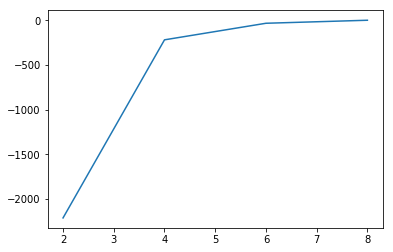

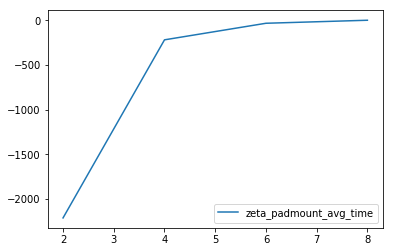

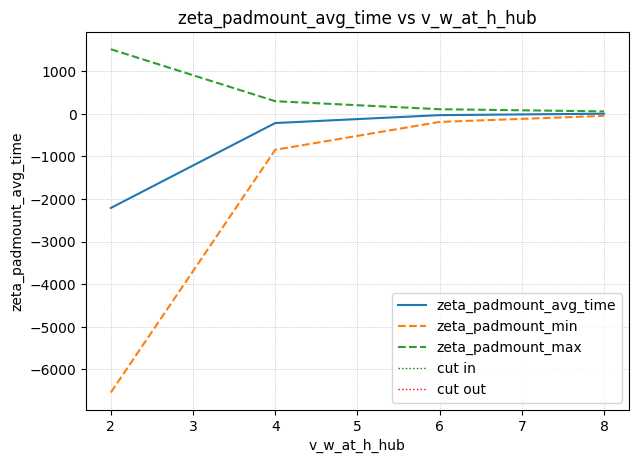

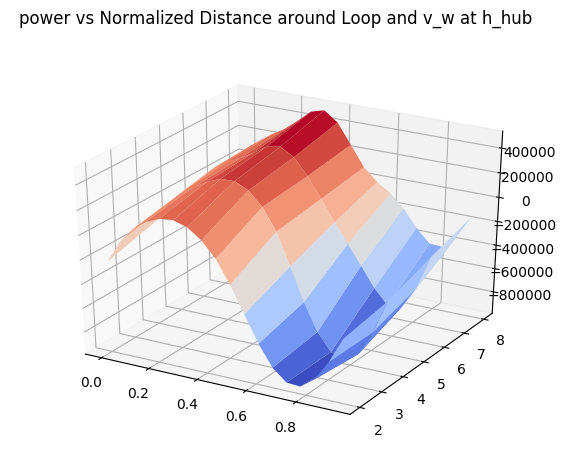

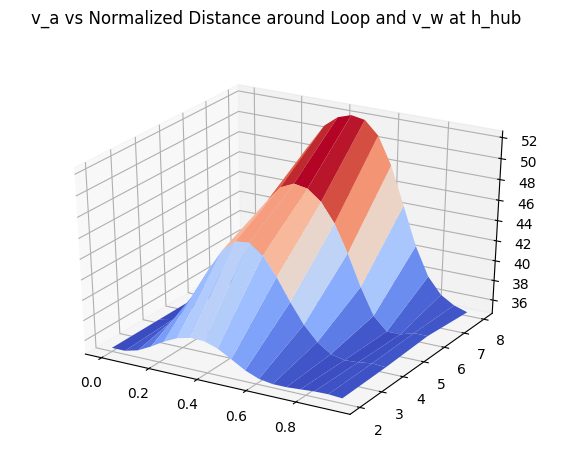

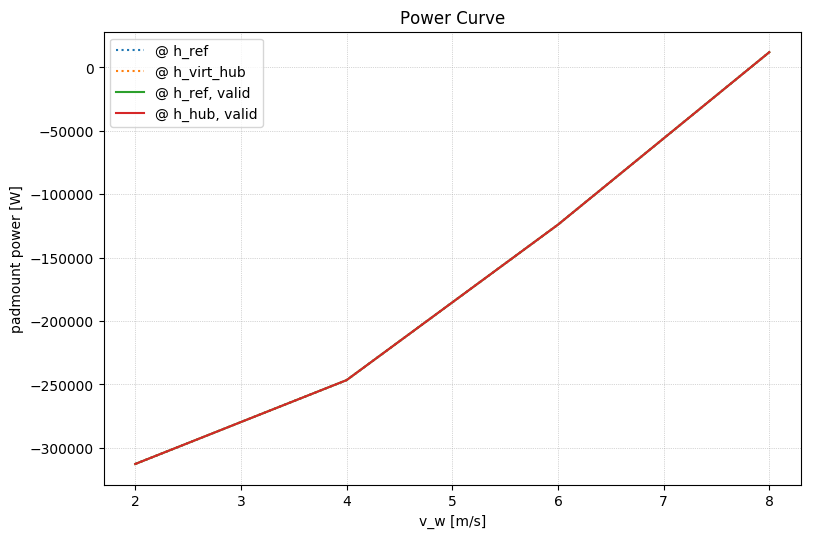

In [10]:
# 1: access data directly, some as attribute, some in data
plt.plot(pc.v_ws_at_h_hub, pc.data_loops['zeta_padmount_avg_time'])

# 2: use dataframe tools
pc.data_loops.plot(y='zeta_padmount_avg_time')

# 3: use built in plotting helper functions
pc.plot_loop_data(ys=['zeta_padmount_avg_time'])
pc.plot_pose_data_as_surf(keys=['power', 'v_a'])
pc.plot_power_curve()

# Putting it all together

This is the minimum set of things needed to calculate a power curve:

This example has NOT removed the roll limits, which is why the power curve has a big dip - when invalid solutions are found, the loop inclination is raised until it works, but this is a big performance hit.

Now solving for v_w at h_ref: 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 
Time to solve power curve is 133.64s


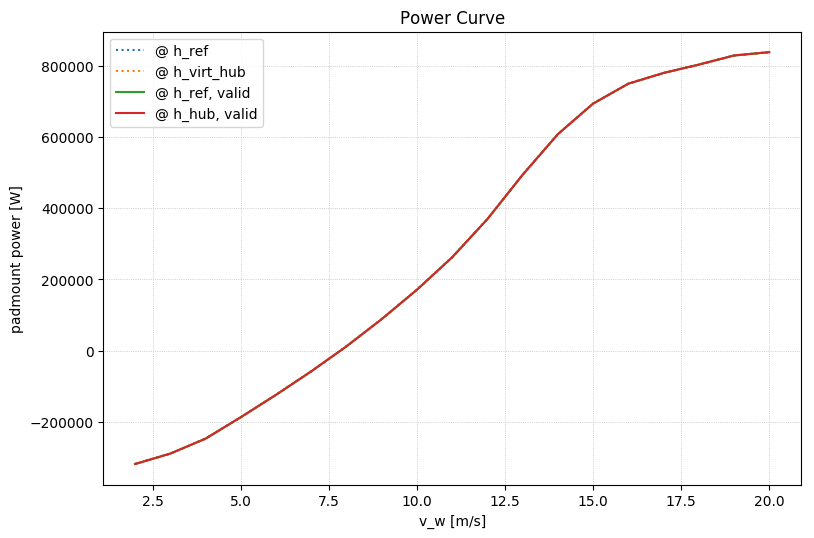

In [11]:
# we need a kite
m600 = cm.GetConfigByName()

# we need a resource
china_lake = rm.GetResourceByName('CL_nom')

# then we make and solve a power curve
m600pc = makani_FBL.KitePowerCurve(china_lake, m600)
m600pc.solve()

# then we do things with it
m600pc.plot_power_curve()